# Comparing XGBoost and TabPFN on a Small Balanced Credit Card Fraud Dataset

A lightweight benchmark using 500 samples with 40% fraud cases
Objective:
Evaluate and compare the performance of XGBoost, a powerful gradient boosting algorithm, and TabPFN, a transformer-based probabilistic model, on a balanced subset of the Credit Card Fraud Detection dataset. This small-scale experiment uses 500 samples (200 fraud, 300 non-fraud) to test model behavior in data-scarce, imbalanced scenarios.

XGBoost (Extreme Gradient Boosting):
XGBoost is a powerful, tree-based ensemble learning algorithm that uses gradient boosting to improve model accuracy. It is optimized for performance and speed, and is widely used for structured or tabular data tasks. XGBoost handles missing values well, supports regularization, and performs effectively on imbalanced datasets.

TabPFN (Tabular Prior-Data Fine-Tuned Network):
TabPFN is a transformer-based probabilistic model designed for tabular data. It is trained on a large set of synthetic tasks to instantly predict posterior probabilities without additional training on the target dataset. TabPFN excels in low-data scenarios, offering calibrated and uncertainty-aware predictions with minimal computation.

The goal is to compare the models in low-data settings, evaluating their accuracy, robustness, and suitability for fraud detection.

We’ll:

Load and preprocess the dataset

Split it into training and testing sets

Train both models

Evaluate performance using classification metrics (AUC, F1, precision-recall)

In [26]:
!pip install tabpfn xgboost shap imbalanced-learn scikit-learn pandas matplotlib seaborn --quiet

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
import shap
import warnings
import torch
import time
from datetime import timedelta
warnings.filterwarnings('ignore')

In [30]:
# Load the small synthetic dataset
df = pd.read_csv('data/small_creditcard_fraud_dataset.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,132174.0,-0.653274,-0.555623,1.164615,-1.136906,-1.158935,0.347023,-0.960906,0.705602,-0.894929,...,0.480673,1.051189,0.174969,-0.447551,-0.870337,-0.143131,0.102650,0.084260,96.00,0
1,148479.0,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,-2.530507,...,1.096405,1.064222,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68,1
2,110028.0,2.027429,-0.108880,-1.304809,0.295299,0.167642,-0.542783,-0.171422,-0.098834,2.056650,...,0.153452,0.715908,0.048887,0.615945,0.213301,-0.502171,-0.035996,-0.067541,1.00,0
3,142961.0,0.457845,1.373769,-0.488926,2.805351,1.777386,0.100492,1.295016,-0.135857,-1.695822,...,0.105593,0.371014,0.051105,0.401524,-0.724766,-0.202881,0.092124,0.094956,0.00,1
4,11080.0,-2.125490,5.973556,-11.034727,9.007147,-1.689451,-2.854415,-7.810441,2.030870,-5.902828,...,1.646518,-0.278485,-0.664841,-1.164555,1.701796,0.690806,2.119749,1.108933,1.00,1


# Splitting the Data and Applying Feature Scaling
This section separates the features and target variable, performs a stratified train-test split to preserve class distribution, and applies standard scaling to normalize feature values before model training.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Training and Evaluating XGBoost and TabPFN on the Fraud Detection Dataset
This section trains an XGBoost classifier as well as TabPFN on the scaled data, makes predictions on the test set, and evaluates model performance using classification metrics, ROC AUC score, and mean absolute error.

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, mean_absolute_error

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

print("📊 XGBoost Metrics")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))


📊 XGBoost Metrics
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        60
           1       0.95      0.90      0.92        40

    accuracy                           0.94       100
   macro avg       0.94      0.93      0.94       100
weighted avg       0.94      0.94      0.94       100

ROC AUC: 0.9333333333333333
MAE: 0.06


In [33]:
from tabpfn import TabPFNClassifier

tabpfn = TabPFNClassifier(device='cpu')
tabpfn.fit(X_train_scaled, y_train)
y_pred_tabpfn = tabpfn.predict(X_test_scaled)

print("📊 TabPFN Metrics")
print(classification_report(y_test, y_pred_tabpfn))
print("ROC AUC:", roc_auc_score(y_test, y_pred_tabpfn))
print("MAE:", mean_absolute_error(y_test, y_pred_tabpfn))


📊 TabPFN Metrics
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.97      0.93      0.95        40

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100

ROC AUC: 0.9541666666666666
MAE: 0.04


# Visual Comparison of Confusion Matrices: XGBoost vs TabPFN
This section presents side-by-side confusion matrices to evaluate and compare the classification performance of XGBoost and TabPFN. The matrices show true positives, true negatives, false positives, and false negatives on the test set.



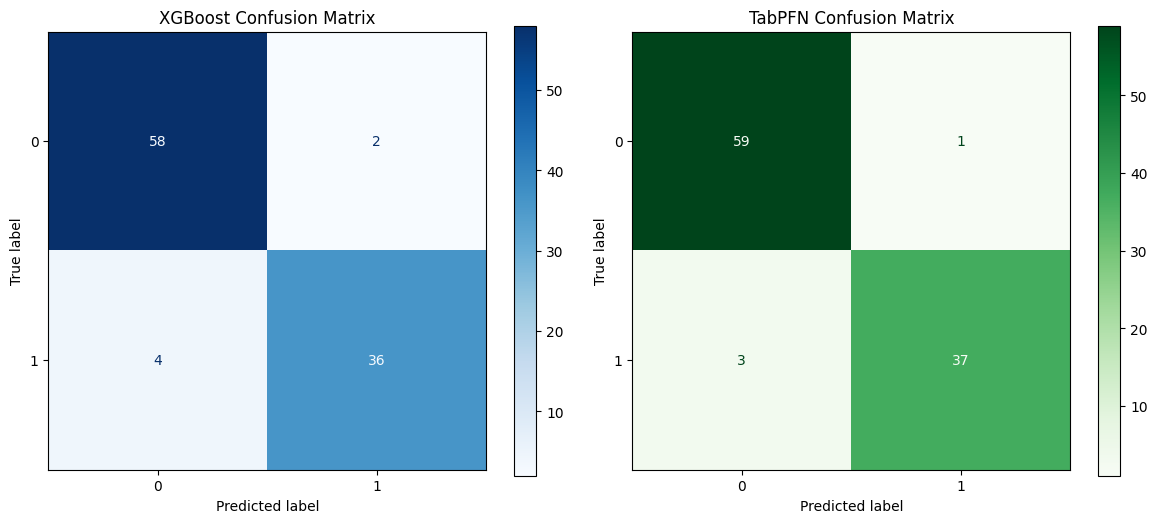

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot(ax=axs[0], cmap="Blues", values_format='d')
axs[0].set_title("XGBoost Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tabpfn)).plot(ax=axs[1], cmap="Greens", values_format='d')
axs[1].set_title("TabPFN Confusion Matrix")

plt.tight_layout()
plt.show()

# ROC Curve Comparison: XGBoost vs TabPFN
This section plots the Receiver Operating Characteristic (ROC) curves for XGBoost and TabPFN, allowing visual comparison of their true positive and false positive trade-offs. The Area Under the Curve (AUC) provides a single-number summary of classifier performance.



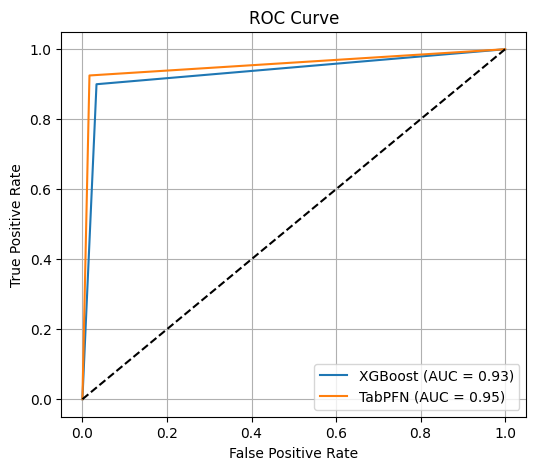

In [38]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
fpr_tab, tpr_tab, _ = roc_curve(y_test, y_pred_tabpfn)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
roc_auc_tab = roc_auc_score(y_test, y_pred_tabpfn)

plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot(fpr_tab, tpr_tab, label=f"TabPFN (AUC = {roc_auc_tab:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# Precision-Recall Curve Comparison: XGBoost vs TabPFN
This section visualizes the precision-recall trade-off for both classifiers. The curve highlights how well each model handles class imbalance, especially in identifying positive (fraudulent) cases.



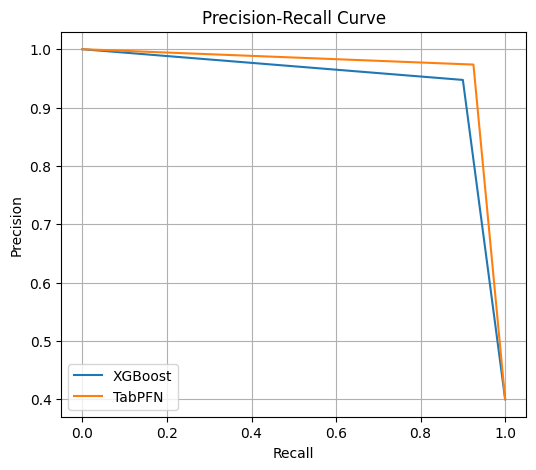

In [39]:
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
prec_tab, rec_tab, _ = precision_recall_curve(y_test, y_pred_tabpfn)

plt.figure(figsize=(6, 5))
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.plot(rec_tab, prec_tab, label="TabPFN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# Overall Performance Comparison of XGBoost and TabPFN
This section consolidates key evaluation metrics—accuracy, precision, recall, F1 score, and ROC AUC—into a single table for a side-by-side comparison of both models.



In [40]:
metrics_df = pd.DataFrame({
    "Model": ["XGBoost", "TabPFN"],
    "Accuracy": [accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_tabpfn)],
    "Precision": [precision_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_tabpfn)],
    "Recall": [recall_score(y_test, y_pred_xgb), recall_score(y_test, y_pred_tabpfn)],
    "F1 Score": [f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_tabpfn)],
    "ROC AUC": [roc_auc_score(y_test, y_pred_xgb), roc_auc_score(y_test, y_pred_tabpfn)],
})

display(metrics_df)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.94,0.947368,0.900,0.923077,0.933333
1,TabPFN,0.96,0.973684,0.925,0.948718,0.954167


# Mean Absolute Error (MAE) Comparison Between XGBoost and TabPFN
This section calculates and visualizes the Mean Absolute Error for both models, providing insight into the average magnitude of prediction errors in the test set.



XGBoost MAE: 0.0600
TabPFN   MAE: 0.0400


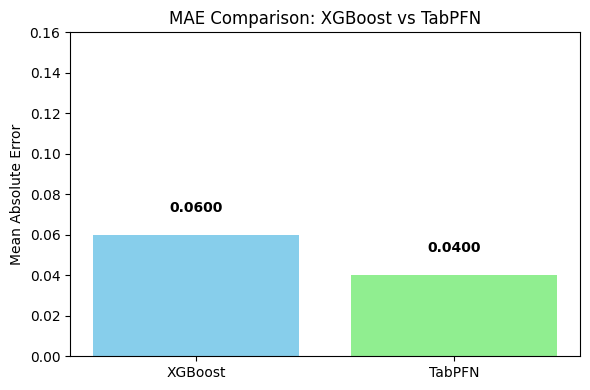

In [41]:
# Calculate MAE for both models
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mae_tab = mean_absolute_error(y_test, y_pred_tabpfn)

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"TabPFN   MAE: {mae_tab:.4f}")

models = ['XGBoost', 'TabPFN']
mae_values = [mae_xgb, mae_tab]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, mae_values, color=['skyblue', 'lightgreen'])
plt.title('MAE Comparison: XGBoost vs TabPFN')
plt.ylabel('Mean Absolute Error')
plt.ylim(0, max(mae_values) + 0.1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# Final Result
This notebook compared XGBoost and TabPFN on a small, balanced credit card fraud detection dataset with 500 samples (40% fraud cases). Both models achieved strong results across all key metrics, but TabPFN consistently outperformed XGBoost:

Higher accuracy, precision, recall, F1 score, and ROC AUC

Lower mean absolute error (MAE)

Better separation in confusion matrix with fewer misclassifications

Given TabPFN’s zero-training paradigm, it's particularly effective in small-data settings like this one. While XGBoost remains a powerful and interpretable baseline, TabPFN proves to be a promising alternative, especially when rapid prototyping or uncertainty-aware predictions are needed.